# REINFORCE Cart Pole Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

import torch
from torch import nn
from torch import optim

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

3.9.5 (default, May 11 2021, 08:20:37) 
[GCC 10.3.0]
1.9.0+cu102
10.2
cuda


## Model

In [7]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n

        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16),
            nn.ReLU(),
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1)
        )

    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))

        return action_probs

## Initialization

In [8]:
env = gym.make('CartPole-v0')
s = env.reset()
pe = policy_estimator(env)

print(pe.predict(s))

tensor([0.5267, 0.4733], grad_fn=<SoftmaxBackward>)


## Discount reward functio

In [4]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])

    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]

    return (r - r.mean()) #/ (r.std() + np.finfo(np.float32).eps)

## The REINFORCE algorithm

In [5]:
def REINFORCE(env, policy_estimator, num_episodes=2000, batch_size=10, gamma=0.99, learning_rate=0.01):

    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions =[]
    batch_states = []
    batch_counter = 1

    #Define Optomozer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=learning_rate)

    action_space = np.arange(env.action_space.n)

    for ep in range(num_episodes):
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        done = False

        while not done:
            #Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)

            s_1, r, done, _ = env.step(action)

            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1

            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))

                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be LongTensor
                    action_tensor = torch.LongTensor(batch_actions)

                    # Calculate loss
                    logprob = torch.log(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = -selected_logprobs.mean()

                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()

                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1

                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(ep + 1, np.mean(total_rewards[-10:])), end="")

    return total_rewards

## Results

Ep: 2000 Average of last 10: 190.10

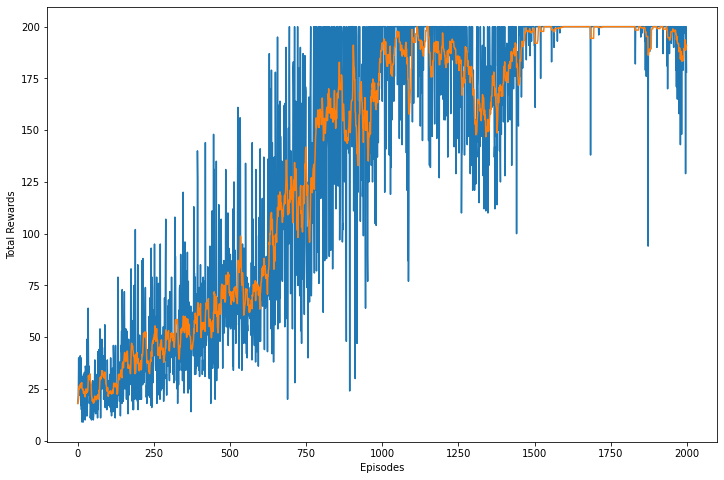

In [6]:
rewards = REINFORCE(env, pe)
window = 10
smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.plot(smoothed_rewards)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()

## Save model

In [ ]:
torch.save(policy_estimator)